<a href="https://colab.research.google.com/github/Skalwalker/AntiMoneyLaundering/blob/main/anti_money_laundering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

The project is based on the analysis of the «IBM Transactions for Anti Money Laundering» dataset published on [Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) and released under the Community Data License Agreement – Sharing – Version 1.0. This dataset contains several CSV files, each having a different combination of data size and amount of illicit transactions.

## About

This project is a partial requisite for completing the courses of "Algorithms for massive datasets" and "Statistical methods for ML" on the masters degree computer science program from Università degli Studi di Milano.

- **Author:** Renato Avellar Nobre
- **Matriculation Number:** 984405
- **Exam Project Year:** 22/23

### Disclaimer

"I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study."


# Overview

The task is to implement a system which predicts whether or not a transaction is illicit, using the attribute "Is Laundering" as a label to be predicted. Classification should be done exploiting a random forest, organizing the project as follows.

1. A sequential implementation (from scratch) of the learning algorithm for a decision tree should be provided, and tested using one or more subsets of the dataset which can be loaded in main memory.

2. A mock-up code that uses spark in order to consider a dataset and processes it in order to distribute the creation of the single trees in a random forest should be proposed. In particular, the construction of each tree should be done by providing different data to each worker, both subsampling the number of rows (i.e., labeled objects) and columns (i.e., attributes) in the overall dataset. Concerning the first kind of subsampling, you might possibly consider introducing the so-called bootstrap sampling, in which the labeled objects are sampled with replacement and therefore a same object can occur more than once in the resulting dataset. It is not required to distribute the creation of a single decision tree: for this task you are free to use the implementation provided in point 1, as well as the implementation already available in scikit-learn.




## Before we start...

Please upload the JSON file of your Kaggle API by executing the code below. Kaggle API JSON files can be generated on your [Kaggle user profile setting](https://www.kaggle.com/settings)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


# Setup

In [ ]:
import os

data_folders = ["01_raw"]

try:
    os.makedirs("data", exist_ok = True)
    [os.makedirs("data/" + folder_name, exist_ok = True) for folder_name in data_folders]
    print("Directories created successfully")
except OSError as error:
    print(f"Directories can not be created: {error}")


Directories created successfully


## Fetching Files from Kaggle

In [ ]:
!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml

100% 7.41G/7.42G [01:52<00:00, 96.2MB/s]
100% 7.42G/7.42G [01:52<00:00, 70.6MB/s]


In [ ]:
!unzip ibm-transactions-for-anti-money-laundering-aml.zip -d ./data/01_raw/

Archive:  ibm-transactions-for-anti-money-laundering-aml.zip
  inflating: ./data/01_raw/HI-Large_Patterns.txt  
  inflating: ./data/01_raw/HI-Large_Trans.csv  
  inflating: ./data/01_raw/HI-Medium_Patterns.txt  
  inflating: ./data/01_raw/HI-Medium_Trans.csv  
  inflating: ./data/01_raw/HI-Small_Patterns.txt  
  inflating: ./data/01_raw/HI-Small_Trans.csv  
  inflating: ./data/01_raw/LI-Large_Patterns.txt  
  inflating: ./data/01_raw/LI-Large_Trans.csv  
  inflating: ./data/01_raw/LI-Medium_Patterns.txt  
  inflating: ./data/01_raw/LI-Medium_Trans.csv  
  inflating: ./data/01_raw/LI-Small_Patterns.txt  
  inflating: ./data/01_raw/LI-Small_Trans.csv  


In [ ]:
!rm ibm-transactions-for-anti-money-laundering-aml.zip
!rm ./data/01_raw/*.txt

## Installations

In [ ]:
!pip install --upgrade ipykernel
!pip install kaggle
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.3 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.23.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=78e05ea15a55225707d3d721e2f494c90cb7788430e9e1c658046a65dc483d14
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully 

## Imports

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets

from pyspark.sql import Window
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, lag, round, lit, to_timestamp, countDistinct, hour, dayofmonth, dayofmonth, minute, date_format, to_date, when, count, row_number, coalesce, unix_timestamp
from pyspark.ml.feature import StringIndexer

## Setting Up PySpark

In [ ]:
spark = None
if spark:
  spark.stop()

spark = SparkSession.builder \
          .appName("MoneyLaundering") \
          .config("spark.executor.memory", "2g") \
          .config("spark.executor.cores", "5") \
          .config("spark.driver.memory", "3g") \
          .config("spark.executor.instances", "4") \
          .config("spark.sql.shuffle.partitions", "16") \
          .getOrCreate()

spark.sparkContext.setLogLevel("OFF")

In [ ]:
for x in spark.sparkContext.getConf().getAll():
  print(f"{x[0].replace('.', ' ').capitalize()}: {x[1]}")

Spark executor memory: 2g
Spark driver port: 40477
Spark executor instances: 4
Spark executor cores: 5
Spark app starttime: 1687950196953
Spark app name: MoneyLaundering
Spark executor id: driver
Spark sql shuffle partitions: 16
Spark driver extrajavaoptions: -Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.sec

# 0. Data Engineering Preparation

In [ ]:
!ls -l --block-size=GB ./data/01_raw/

total 41GB
-rw-r--r-- 1 root root 18GB Feb 28 11:54 HI-Large_Trans.csv
-rw-r--r-- 1 root root  4GB Feb 28 12:08 HI-Medium_Trans.csv
-rw-r--r-- 1 root root  1GB Feb 28 12:12 HI-Small_Trans.csv
-rw-r--r-- 1 root root 17GB Feb 28 12:12 LI-Large_Trans.csv
-rw-r--r-- 1 root root  3GB Feb 28 12:28 LI-Medium_Trans.csv
-rw-r--r-- 1 root root  1GB Feb 28 12:31 LI-Small_Trans.csv


## Raw Data

The raw layer is the starting point of the data pipeline and includes the sourced data model(s) that should never be altered. It serves as the single source of truth for all subsequent work. Typically, these data models are untyped, such as CSV files.

* We never mutate the data here, only work on copies.



In [ ]:
# High Ilicity Datasets
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True)
hi_large_df = spark.read.csv("./data/01_raw/HI-Large_Trans.csv", header=True)

# Low Ilicity Datasets
li_small_df = spark.read.csv("./data/01_raw/LI-Small_Trans.csv", header=True)
li_large_df = spark.read.csv("./data/01_raw/LI-Large_Trans.csv", header=True)

In [ ]:
hi_small_df.columns

['Timestamp',
 'From Bank',
 'Account2',
 'To Bank',
 'Account4',
 'Amount Received',
 'Receiving Currency',
 'Amount Paid',
 'Payment Currency',
 'Payment Format',
 'Is Laundering']

In [ ]:
hi_small_df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [ ]:
# Verify if all columns are equal
hi_cols_equal = (hi_small_df.columns == hi_large_df.columns)
li_cols_equal = (li_large_df.columns == li_small_df.columns)

print(f"Are all HI cols the same? {hi_cols_equal}")
print(f"Are all LI cols the same? {li_cols_equal}")
print(f"Are LI cols the same in HI? {hi_cols_equal == li_cols_equal}")

Are all HI cols the same? True
Are all LI cols the same? True
Are LI cols the same in HI? True


In [ ]:
hi_small_df.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:20|      010|8000EBD30|    010|8000EBD30|        3697.34|         US Dollar|    3697.34|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:20|    03208|8000F4580|    001|8000F5340|           0.01|         US Dollar|       0.01|       US Dollar|        Cheque|            0|
|2022/09/01 00:00|    03209|8000F4670|  03209|8000F4670|       14675.57|         US Dollar|   14675.57|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:02|      012|8000F5030|    012|8000F5030|        2806.97|         US Dollar|    2806.

In [ ]:
null_counts = hi_small_df.select([sum(col(column).isNull().cast("integer")).alias(column) for column in hi_small_df.columns])
null_counts.show()

+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|Timestamp|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+
|        0|        0|       0|      0|       0|              0|                 0|          0|               0|             0|            0|
+---------+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+



## Intermediate Data

In practice the intermediate layer only needs to be a typed mirror of the raw layer still within the ‘source’ data model

* Once the intermediate layer exists, you never have to touch the raw layer and we eliminate the risks associated with mutating the original data.

* Profiling, EDA and any data quality assessments should be performed at this point.

* Cleaning column names, parsing dates and dropping completely null columns are other ‘transformations’ commonly performed at this stage.

In [ ]:
schema = StructType([
    StructField("Timestamp", StringType(), nullable=False),
    StructField("From Bank", IntegerType(), nullable=False),
    StructField("Account2", StringType(), nullable=False),
    StructField("To Bank", IntegerType(), nullable=False),
    StructField("Account4", StringType(), nullable=False),
    StructField("Amount Received", FloatType(), nullable=False),
    StructField("Receiving Currency", StringType(), nullable=False),
    StructField("Amount Paid", FloatType(), nullable=False),
    StructField("Payment Currency", StringType(), nullable=False),
    StructField("Payment Format", StringType(), nullable=False),
    StructField("Is Laundering", IntegerType(), nullable=False),
])

In [ ]:
hi_small_df = spark.read.csv("./data/01_raw/HI-Small_Trans.csv", header=True, schema=schema)
hi_large_df = spark.read.csv("./data/01_raw/HI-Large_Trans.csv", header=True, schema=schema)
li_small_df = spark.read.csv("./data/01_raw/LI-Small_Trans.csv", header=True, schema=schema)
li_large_df = spark.read.csv("./data/01_raw/LI-Large_Trans.csv", header=True, schema=schema)

# Fixing Timestamp
def fix_timestamp(df):
  format = "yyyy/MM/dd HH:mm"
  df = df.withColumn("Timestamp2",to_timestamp("Timestamp", format=format).cast('timestamp'))
  df = df.drop("Timestamp")
  df = df.withColumnRenamed("Timestamp2", "Timestamp")
  return df

hi_small_df = fix_timestamp(hi_small_df)
hi_large_df = fix_timestamp(hi_large_df)
li_small_df = fix_timestamp(li_small_df)
li_large_df = fix_timestamp(li_large_df)

In [ ]:
li_small_df.printSchema()

root
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: float (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: float (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)
 |-- Timestamp: timestamp (nullable = true)



In [ ]:
li_small_df.show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|       11|8000ECA90|     11|8000ECA90|      3195403.0|         US Dollar|  3195403.0|       US Dollar|  Reinvestment|            0|2022-09-01 00:08:00|
|     3402|80021DAD0|   3402|80021DAD0|        1858.96|         US Dollar|    1858.96|       US Dollar|  Reinvestment|            0|2022-09-01 00:21:00|
|       11|8000ECA90|   1120|8006AA910|       592571.0|         US Dollar|   592571.0|       US Dollar|        Cheque|            0|2022-09-01 00:00:00|
|     3814|8006AD080|   3814|8006AD080|          12.32|         US Dollar|      12

### Exploratory Data Analysis
---

For simplicity and time saving we will analyse only the LI Datasets

**Insights:**


* Reinvestment doesn't appear to have money laundry
* Laundering occur in self transactions in few cases
* Accounts are identifiers of the transaction
* There is no money laundring happening in between currencies. Which mean we can keep only one variable for Receiving Currency and Payment Currency, and Amount Received and Amount Paid


**Possible Features:**

* Self Transaction flag
* Time of the day transaction
* Day of the month transaction?
* Number of transactions in the day


In [ ]:
small_df = li_small_df
large_df = li_large_df

#### Small Dataset Analysis

In [ ]:
# Get the label distribution in the dataset
small_df.groupBy("Is Laundering").count().show()

+-------------+-------+
|Is Laundering|  count|
+-------------+-------+
|            1|   3565|
|            0|6920484|
+-------------+-------+



In [ ]:
# Split the dataset into Legit and Laundering Transactions to analyze the feature in each case
small_laundering_df = small_df.filter(small_df["Is Laundering"] == 1)
small_legit_df = small_df.filter(small_df["Is Laundering"] == 0)

float_columns = ["Amount Received", "Amount Paid"]
small_laundering_df.select(float_columns).describe().show()
small_legit_df.select(float_columns).describe().show()

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|                3565|                3565|
|   mean|  3626202.3871408654|  3626202.3871408654|
| stddev|6.2200284356123395E7|6.2200284356123395E7|
|    min|            0.001136|            0.001136|
|    max|        2.47329536E9|        2.47329536E9|
+-------+--------------------+--------------------+

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|             6920484|             6920484|
|   mean|  6325456.3603514815|  4676576.7705724845|
| stddev|2.1059128350347283E9|1.5444954950918577E9|
|    min|              1.0E-6|              1.0E-6|
|    max|       3.64485358E12|       3.64485358E12|
+-------+--------------------+--------------------+



In [ ]:
# Distinct Ilegal Accounts
small_laundering_df.select(countDistinct("Account2")).first()[0]

2382

In [ ]:
# Analysis of Ilegality through payment formats
small_laundering_df.groupBy("Payment Format").count().show()
small_legit_df.groupBy("Payment Format").count().show()

+--------------+-----+
|Payment Format|count|
+--------------+-----+
|   Credit Card|  261|
|           ACH| 2611|
|          Cash|  124|
|       Bitcoin|  110|
|        Cheque|  459|
+--------------+-----+

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|   Credit Card|1780128|
|           ACH| 793970|
|          Wire| 228567|
|          Cash| 655564|
|       Bitcoin| 309098|
|  Reinvestment| 650458|
|        Cheque|2502699|
+--------------+-------+



In [ ]:
# Show ilegal transactions are made for the same account
small_laundering_df.filter(small_laundering_df["Account2"] == small_laundering_df["Account4"]).show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|      115|81522E390|    115|81522E390|       40877.23|            Shekel|   40877.23|          Shekel|           ACH|            1|2022-09-03 08:56:00|
|    13354|802E1FDA0|  13354|802E1FDA0|        3038.63|         US Dollar|    3038.63|       US Dollar|           ACH|            1|2022-09-05 10:21:00|
|    25788|8026EA1A0|  25788|8026EA1A0|        4418.15|              Euro|    4418.15|            Euro|           ACH|            1|2022-09-10 15:58:00|
+---------+---------+-------+---------+---------------+------------------+--------

In [ ]:
# Show ilegal transactions difference in payment ammount
small_laundering_df.filter(small_laundering_df["Amount Paid"] != small_laundering_df["Amount Received"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [ ]:
# Show ilegal transactions in different currencies
small_laundering_df.filter(small_laundering_df["Receiving Currency"] != small_laundering_df["Payment Currency"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [ ]:
small_laundering_df.groupBy("Receiving Currency").count().show()
small_laundering_df.groupBy("Payment Currency").count().show()

+------------------+-----+
|Receiving Currency|count|
+------------------+-----+
|         US Dollar| 1456|
|              Euro| 1025|
|              Yuan|  189|
|       Brazil Real|   72|
|   Canadian Dollar|   86|
|       Saudi Riyal|  115|
| Australian Dollar|   77|
|             Rupee|  112|
|      Mexican Peso|   37|
|             Ruble|   39|
|          UK Pound|   40|
|               Yen|   86|
|           Bitcoin|  110|
|       Swiss Franc|   56|
|            Shekel|   65|
+------------------+-----+

+-----------------+-----+
| Payment Currency|count|
+-----------------+-----+
|        US Dollar| 1456|
|             Euro| 1025|
|             Yuan|  189|
|      Brazil Real|   72|
|  Canadian Dollar|   86|
|      Saudi Riyal|  115|
|Australian Dollar|   77|
|            Rupee|  112|
|     Mexican Peso|   37|
|            Ruble|   39|
|         UK Pound|   40|
|              Yen|   86|
|          Bitcoin|  110|
|      Swiss Franc|   56|
|           Shekel|   65|
+-----------------

**Account-related analysis:**

* Account activity: Unusually high transaction activity or a large number of accounts linked to a particular entity may indicate suspicious behavior.

* Create features that capture the frequency and volume of transactions from both the "From Account" and "To Account."
* Including the account identifiers as features may introduce data leakage because the model can learn patterns specific to  accounts.
* The destination bank appears to have strong predictive power in this case.
* The destination accounts as well, it appears to be accounts never used before.

In [ ]:
small_legit_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|       70|10042B6A8|     14|8000FEFD0|       33199.17|              Euro|   33199.17|            Euro|        Cheque|            0|2022-09-01 00:04:00|
|       70|10042B6A8|     20|80011ABE0|       30999.19|              Euro|   30999.19|            Euro|        Cheque|            0|2022-09-01 00:09:00|
|       70|10042B6A8|     20|8001AB3F0|        1445.39|              Euro|    1445.39|            Euro|        Cheque|            0|2022-09-01 00:19:00|
|       70|10042B6A8|     20|8001AB3F0|         706.43|              Euro|     706

In [ ]:
small_laundering_df.where(small_laundering_df["Account2"] == "10042B6A8").show(10)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|       70|10042B6A8| 212854|806242CD0|       22478.74|              Euro|   22478.74|            Euro|          Cash|            1|2022-09-01 00:03:00|
|       70|10042B6A8| 115332|806573660|      9626868.0|              Euro|  9626868.0|            Euro|          Cash|            1|2022-09-01 00:03:00|
|       70|10042B6A8|  38920|80E95DAC0|         323.25|              Euro|     323.25|            Euro|   Credit Card|            1|2022-09-01 00:59:00|
|       70|10042B6A8|  24643|801F02820|        3572.59|              Euro|    3572

In [ ]:
receinving_accs = ["806242CD0", "806573660", "80E95DAC0", "801F02820", "805F99460",
                   "80AEDE4A0", "80B2862D0", "816325220", "8041E5A30", "8007D19B0"]
small_laundering_df.where(small_laundering_df["Account2"].isin(receinving_accs)).show(10)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|      425|8041E5A30|   6681|8041E59E0|        2336.89|              Euro|    2336.89|            Euro|           ACH|            1|2022-09-01 13:58:00|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+



**Time-related analysis:**

* Extract day of the week: Convert the timestamp into a day of the week feature. Illegal transactions may exhibit certain patterns or anomalies depending on the day of the week.

* Extract hour of the day: Convert the timestamp into an hour of the day feature. Similar to the day of the week, certain hours may be more associated with illegal activities.

In [ ]:
weekly_laundering = small_laundering_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_legit = small_legit_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_laundering.join(weekly_legit.withColumnRenamed("count", "count2"), "Weekday"). \
                 withColumn("Laundering Rate", col("count") / col("count2")). \
                 withColumn("Laundering Rate", col("Laundering Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Laundering Rate").desc()). \
                 show()

+---------+-----+-------+---------------+
|  Weekday|count| count2|Laundering Rate|
+---------+-----+-------+---------------+
|   Sunday|  338| 282215|   0.0011976684|
| Saturday|  595| 565611|   0.0010519597|
|  Tuesday|  409| 656809|   0.0006227077|
|   Monday|  397| 657048|   0.0006042177|
|Wednesday|  386| 658149|   0.0005864933|
|   Friday|  722|1918616|   0.0003763129|
| Thursday|  718|2182036|   0.0003290505|
+---------+-----+-------+---------------+



In [ ]:
hourly_laundering = small_laundering_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_legit = small_legit_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_laundering.join(hourly_legit.withColumnRenamed("count", "count2"), "Hour"). \
                 withColumn("Hourly Rate", col("count") / col("count2")). \
                 withColumn("Hourly Rate", col("Hourly Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Hourly Rate").desc()). \
                 show()

In [ ]:
daily_laundering = small_laundering_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_legit = small_legit_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_laundering.join(daily_legit.withColumnRenamed("count", "count2"), "Date"). \
                 withColumn("Daily Rate", col("count") / col("count2")). \
                 withColumn("Daily Rate", col("Daily Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Daily Rate").desc()). \
                 show()

+----+-----+-------+------------+
|Date|count| count2|  Daily Rate|
+----+-----+-------+------------+
|  16|    5|      2|2.5000000000|
|  15|    6|      3|2.0000000000|
|  17|    2|      1|2.0000000000|
|  11|   47|     30|1.5666666667|
|  13|   29|     19|1.5263157895|
|  14|   18|     13|1.3846153846|
|  12|   27|     21|1.2857142857|
|  10|  301| 282576|0.0010652002|
|   3|  292| 283034|0.0010316782|
|   4|  291| 282185|0.0010312384|
|   8|  402| 657536|0.0006113734|
|   6|  380| 656790|0.0005785715|
|   5|  370| 657027|0.0005631428|
|   7|  368| 658136|0.0005591549|
|   9|  367| 891206|0.0004118015|
|   2|  350|1027408|0.0003406631|
|   1|  310|1524497|0.0002033458|
+----+-----+-------+------------+



In [ ]:
# Isnt small simulation supposed to be 10 days?
small_df.withColumn("Date", to_date('Timestamp')).groupby("Date").count().show()

+----------+-------+
|      Date|  count|
+----------+-------+
|2022-09-02|1027758|
|2022-09-06| 657170|
|2022-09-04| 282476|
|2022-09-05| 657397|
|2022-09-03| 283326|
|2022-09-01|1524807|
|2022-09-10| 282877|
|2022-09-07| 658504|
|2022-09-09| 891573|
|2022-09-08| 657938|
|2022-09-12|     48|
|2022-09-11|     77|
|2022-09-13|     48|
|2022-09-15|      9|
|2022-09-14|     31|
|2022-09-17|      3|
|2022-09-16|      7|
+----------+-------+



In [ ]:
# Very odd
small_df.where(to_date(col("Timestamp")).cast("string") == "2022-09-16").show()

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+
|     1291|8001F2990|      1|8002BBDF0|        3419.89|         US Dollar|    3419.89|       US Dollar|           ACH|            1|2022-09-16 00:00:00|
|     1291|8001F2990|     12|8001F8B00|        8515.97|         US Dollar|    8515.97|       US Dollar|           ACH|            1|2022-09-16 12:41:00|
|       11|8001AB0D0|     20|801CD38E0|         693.55|              Euro|     693.55|            Euro|           ACH|            1|2022-09-16 06:54:00|
|       11|8001AB0D0|     11|8001AB0D0|        6921.45|         US Dollar|    5906

#### Large Dataset Analysis

In [ ]:
# Get the label distribution in the dataset
large_df.groupBy("Is Laundering").count().show()

+-------------+---------+
|Is Laundering|    count|
+-------------+---------+
|            1|   100604|
|            0|175965953|
+-------------+---------+



In [ ]:
# Split the dataset into Legit and Laundering Transactions to analyze the feature in each case
large_laundering_df = large_df.filter(large_df["Is Laundering"] == 1)
large_legit_df = large_df.filter(large_df["Is Laundering"] == 0)

float_columns = ["Amount Received", "Amount Paid"]
large_laundering_df.select(float_columns).describe().show()
large_legit_df.select(float_columns).describe().show()

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|              100604|              100604|
|   mean|5.7111282719604835E7|5.7111282719604835E7|
| stddev|3.7370226655451694E9|3.7370226655451694E9|
|    min|             2.81E-4|             2.81E-4|
|    max|        6.2154002E11|        6.2154002E11|
+-------+--------------------+--------------------+

+-------+--------------------+--------------------+
|summary|     Amount Received|         Amount Paid|
+-------+--------------------+--------------------+
|  count|           175965953|           175965953|
|   mean|   7238086.466158445|   4857038.847415218|
| stddev|1.7038381685874453E9|1.2869724486626391E9|
|    min|              1.0E-6|              1.0E-6|
|    max|        4.8345818E12|        4.8345818E12|
+-------+--------------------+--------------------+



In [ ]:
# Distinct Ilegal Accounts
large_laundering_df.select(countDistinct("Account2")).first()[0]

60608

In [ ]:
# Analysis of Ilegality through payment formats
large_laundering_df.groupBy("Payment Format").count().show()
large_legit_df.groupBy("Payment Format").count().show()

+--------------+-----+
|Payment Format|count|
+--------------+-----+
|   Credit Card| 7554|
|           ACH|75031|
|          Cash| 3514|
|       Bitcoin| 1499|
|        Cheque|13003|
|          Wire|    3|
+--------------+-----+

+--------------+--------+
|Payment Format|   count|
+--------------+--------+
|   Credit Card|49904336|
|           ACH|21492746|
|          Cash|18037238|
|          Wire| 6339914|
|       Bitcoin| 3585151|
|  Reinvestment| 7258238|
|        Cheque|69348330|
+--------------+--------+



In [ ]:
# Count how many ilegal transactions are made for the same account
large_laundering_df.filter(large_laundering_df["Account2"] == large_laundering_df["Account4"]).count()

41

In [ ]:
large_laundering_df.filter(large_laundering_df["Amount Paid"] != large_laundering_df["Amount Received"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [ ]:
# Show ilegal transactions in different currencies
large_laundering_df.filter(large_laundering_df["Receiving Currency"] != large_laundering_df["Payment Currency"]).show()

+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
|From Bank|Account2|To Bank|Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|Timestamp|
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+
+---------+--------+-------+--------+---------------+------------------+-----------+----------------+--------------+-------------+---------+



In [ ]:
large_laundering_df.groupBy("Receiving Currency").count().show()
large_laundering_df.groupBy("Payment Currency").count().show()

+------------------+-----+
|Receiving Currency|count|
+------------------+-----+
|         US Dollar|38346|
|              Euro|26022|
|              Yuan| 5597|
|       Brazil Real| 2265|
|   Canadian Dollar| 3178|
|             Rupee| 3896|
| Australian Dollar| 2764|
|       Saudi Riyal| 1662|
|             Ruble| 2906|
|               Yen| 3363|
|          UK Pound| 2960|
|           Bitcoin| 1499|
|       Swiss Franc| 2532|
|      Mexican Peso| 1774|
|            Shekel| 1840|
+------------------+-----+

+-----------------+-----+
| Payment Currency|count|
+-----------------+-----+
|        US Dollar|38346|
|             Euro|26022|
|             Yuan| 5597|
|      Brazil Real| 2265|
|  Canadian Dollar| 3178|
|            Rupee| 3896|
|Australian Dollar| 2764|
|      Saudi Riyal| 1662|
|            Ruble| 2906|
|              Yen| 3363|
|         UK Pound| 2960|
|          Bitcoin| 1499|
|      Swiss Franc| 2532|
|     Mexican Peso| 1774|
|           Shekel| 1840|
+-----------------

**Time-related analysis:**

* Extract day of the week: Convert the timestamp into a day of the week feature. Illegal transactions may exhibit certain patterns or anomalies depending on the day of the week.

* Extract hour of the day: Convert the timestamp into an hour of the day feature. Similar to the day of the week, certain hours may be more associated with illegal activities.

In [ ]:
weekly_laundering = large_laundering_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_legit = large_legit_df.withColumn("Weekday", date_format('Timestamp', 'EEEE')).groupBy("Weekday").count().cache()
weekly_laundering.join(weekly_legit.withColumnRenamed("count", "count2"), "Weekday"). \
                 withColumn("Laundering Rate", col("count") / col("count2")). \
                 withColumn("Laundering Rate", col("Laundering Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Laundering Rate").desc()). \
                 show()

+---------+-----+--------+---------------+
|  Weekday|count|  count2|Laundering Rate|
+---------+-----+--------+---------------+
| Saturday|12796|11386828|   0.0011237546|
|   Sunday|12051|12931953|   0.0009318778|
| Thursday|14863|26463559|   0.0005616403|
|  Tuesday|14787|26468510|   0.0005586639|
|Wednesday|14903|28778723|   0.0005178479|
|   Monday|14825|28965215|   0.0005118208|
|   Friday|16379|40971165|   0.0003997690|
+---------+-----+--------+---------------+



In [ ]:
hourly_laundering = large_laundering_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_legit = large_legit_df.withColumn("Hour", hour('Timestamp')).groupBy("Hour").count().cache()
hourly_laundering.join(hourly_legit.withColumnRenamed("count", "count2"), "Hour"). \
                 withColumn("Hourly Rate", col("count") / col("count2")). \
                 withColumn("Hourly Rate", col("Hourly Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Hourly Rate").desc()). \
                 show()

+----+-----+-------+------------+
|Hour|count| count2| Hourly Rate|
+----+-----+-------+------------+
|  12| 4846|6855024|0.0007069268|
|  11| 4831|6851304|0.0007051212|
|  16| 4835|6858909|0.0007049226|
|  15| 4709|6854639|0.0006869800|
|  13| 4698|6860037|0.0006848360|
|  14| 4691|6856477|0.0006841706|
|  18| 4386|6860614|0.0006393014|
|  19| 4344|6857660|0.0006334522|
|  17| 4279|6853010|0.0006243972|
|  10| 4268|6848716|0.0006231825|
|   8| 4237|6855684|0.0006180273|
|   9| 4215|6851019|0.0006152369|
|   5| 4128|6861127|0.0006016504|
|   7| 4108|6856407|0.0005991476|
|   6| 3979|6862286|0.0005798359|
|   3| 3890|6861294|0.0005669485|
|   2| 3850|6858052|0.0005613839|
|   4| 3816|6852737|0.0005568578|
|   1| 3801|6870525|0.0005532328|
|  22| 3719|6851093|0.0005428331|
+----+-----+-------+------------+
only showing top 20 rows



In [ ]:
daily_laundering = large_laundering_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_legit = large_legit_df.withColumn("Date", dayofmonth('Timestamp')).groupBy("Date").count().cache()
daily_laundering.join(daily_legit.withColumnRenamed("count", "count2"), "Date"). \
                 withColumn("Daily Rate", col("count") / col("count2")). \
                 withColumn("Daily Rate", col("Daily Rate").cast('Decimal(20,10)')). \
                 orderBy(col("Daily Rate").desc()). \
                 show()

+----+-----+-------+------------+
|Date|count| count2|  Daily Rate|
+----+-----+-------+------------+
|  25| 3190|4594404|0.0006943229|
|  20| 3143|4594374|0.0006840976|
|  29| 3143|4596368|0.0006838008|
|  27| 3089|4590902|0.0006728525|
|  18| 3084|4592763|0.0006714912|
|  22| 3076|4596914|0.0006691446|
|   8| 3059|4595246|0.0006656880|
|  15| 3050|4594305|0.0006638654|
|  11| 3037|4592294|0.0006613253|
|  24| 3026|4592248|0.0006589365|
|  17| 3005|4593527|0.0006541814|
|   6| 2993|4594398|0.0006514455|
|  13| 2965|4594941|0.0006452749|
|  10| 2944|4592106|0.0006411002|
|  23| 3178|5271296|0.0006028878|
|   9| 3167|5271940|0.0006007276|
|   3| 3861|6484799|0.0005953924|
|  21| 3086|5272882|0.0005852587|
|  28| 3288|5654568|0.0005814768|
|   7| 3004|5272204|0.0005697807|
+----+-----+-------+------------+
only showing top 20 rows



## Feature Data


The feature data layer comprises an analytics-specific data model that includes a collection of features defined based on the primary data. In practical terms, this layer represents both the independent variables and the target variable, which serve as the foundation for exploring and applying machine learning techniques.

In [ ]:
def create_time_features(ds):
  ds = ds.withColumn("Hour", hour('Timestamp'))
  ds = ds.withColumn("Day", dayofmonth('Timestamp'))
  ds = ds.withColumn("Minute", minute('Timestamp'))
  ds = ds.withColumn("Date", to_date('Timestamp'))
  ds = ds.withColumn("Weekday", date_format('Timestamp', 'EEEE'))
  return ds

small_df = create_time_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|
+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+-------------------+----+---+------+----------+--------+
|       11|8000ECA90|     11|8000ECA90|      3195403.0|         US Dollar|  3195403.0|       US Dollar|  Reinvestment|            0|2022-09-01 00:08:00|   0|  1|     8|2022-09-01|Thursday|
|     3402|80021DAD0|   3402|80021DAD0|        1858.96|         US Dollar|    1858.96|       US Dollar|  Reinvestment|            0|2022-09-01 00:21:00|   0|  1|    21|2022-09-01|Thursday|
|       11|8000ECA90|   1120|8006AA910|       592571.0|

In [ ]:
def create_self_payment_feature(ds):
  ds = ds.withColumn("SelfPayment", when(col("Account2") == col("Account4"), 1).otherwise(0))
  return ds

def clean_payment_format(ds):
  ds = ds.where(col("Payment Format") != "Reinvestment")
  return ds

small_df = create_self_payment_feature(small_df)
small_df = clean_payment_format(small_df)
small_df.groupBy("Payment Format").count().show()
small_df.groupBy("SelfPayment").count().show()

+--------------+-------+
|Payment Format|  count|
+--------------+-------+
|   Credit Card|1780389|
|           ACH| 796581|
|          Wire| 228567|
|          Cash| 655688|
|       Bitcoin| 309208|
|        Cheque|2503158|
+--------------+-------+

+-----------+-------+
|SelfPayment|  count|
+-----------+-------+
|          1| 154019|
|          0|6119572|
+-----------+-------+



In [ ]:
def create_currency_features(ds):
  ds = ds.withColumn("SameCurrencyTransaction", when(col("Receiving Currency") == col("Payment Currency"), 1).otherwise(0))
  ds = ds.drop("Payment Currency")
  ds = ds.withColumnRenamed("Receiving Currency", "Currency")
  return ds

small_df = create_currency_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|From Bank| Account2|To Bank| Account4|Amount Received| Currency|Amount Paid|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|
+---------+---------+-------+---------+---------------+---------+-----------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+
|       11|8000ECA90|   1120|8006AA910|       592571.0|US Dollar|   592571.0|        Cheque|            0|2022-09-01 00:00:00|   0|  1|     0|2022-09-01|Thursday|          0|                      1|
|       11|800059120|   1217|8006AD4E0|        60562.0|US Dollar|    60562.0|           ACH|            0|2022-09-01 00:17:00|   0|  1|    17|2022-09-01|Thursday|          0|                      1|
|    

In [ ]:
def create_ammount_features(ds):
  ds = ds.withColumn("AmtReceivedRatio",  col("Amount Received") / col("Amount Paid"))
  ds = ds.drop("Amount Paid")
  ds = ds.withColumnRenamed("Amount Received", "AmtReceived")
  return ds

small_df = create_ammount_features(small_df)
small_df.show(5)

+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|From Bank| Account2|To Bank| Account4|AmtReceived| Currency|Payment Format|Is Laundering|          Timestamp|Hour|Day|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|
+---------+---------+-------+---------+-----------+---------+--------------+-------------+-------------------+----+---+------+----------+--------+-----------+-----------------------+----------------+
|       11|8000ECA90|   1120|8006AA910|   592571.0|US Dollar|        Cheque|            0|2022-09-01 00:00:00|   0|  1|     0|2022-09-01|Thursday|          0|                      1|             1.0|
|       11|800059120|   1217|8006AD4E0|    60562.0|US Dollar|           ACH|            0|2022-09-01 00:17:00|   0|  1|    17|2022-09-01|Thursday|          0|                      1|             1.0|


In [ ]:
def trans_by_acc_features(ds):
  # Total Transaction Ammount in Hour
  temp = ds.groupBy("Account2", "Hour").agg(count("*").alias("AccTransAmtInHour")).cache()
  ds = ds.join(temp, on=["Account2", "Hour"], how="left")
  # Total Transaction Ammount in Day
  temp = ds.groupBy("Account2", "Day").agg(count("*").alias("AccTransAmtInDay")).cache()
  ds = ds.join(temp, on=["Account2", "Day"], how="left")

  # Transaction Number by the Account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('AccTransNumByHour', row_number().over(w))
  # Transaction Number by the Account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('AccTransNumByDay', row_number().over(w))

  # Time in mins since last transaction
  w = Window.partitionBy(ds["Account2"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTrans", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))

  return ds

small_df = trans_by_acc_features(small_df)

In [ ]:
def receiving_acc_features(ds):
  # Total Transaction Ammount to same account in Hour
  temp = ds.groupBy("Account2", "Account4", "Hour").agg(count("*").alias("HourAccTransAmtToSameAcc")).cache()
  ds = ds.join(temp, on=["Account2", "Account4", "Hour"], how="left")
  # Total Transaction Ammount to same account in Day
  temp = ds.groupBy("Account2", "Account4", "Day").agg(count("*").alias("DayAccTransAmtToSameAcc")).cache()
  ds = ds.join(temp, on=["Account2", "Account4", "Day"], how="left")

  # Transaction Number by the Account to same account in the Hour
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"], ds["Hour"]).orderBy(ds["Minute"])
  ds = ds.withColumn('HourAccTransNumToSameAcc', row_number().over(w))
  # Transaction Number by the Account to same account in the Day
  w = Window.partitionBy(ds["Account2"], ds["Account4"], ds["Date"]).orderBy(ds["Hour"], ds["Minute"])
  ds = ds.withColumn('DayAccTransNumToSameAcc', row_number().over(w))

  # Time in mins since last transaction to same account
  w = Window.partitionBy(ds["Account2"], ds["Account4"]).orderBy(ds["Timestamp"])
  ds = ds.withColumn("MinsSinceLastTransToSameAcc", coalesce(round((unix_timestamp("Timestamp") - lag(unix_timestamp("Timestamp"), 1).over(w))/60), lit(0)))


  return ds

small_df = receiving_acc_features(small_df)

In [ ]:
small_df.where(col("Account2") == "8000ECA90").show()

+---------+---------+---+----+---------+-------+-----------+---------------+--------------+-------------+-------------------+------+----------+--------+-----------+-----------------------+------------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+
| Account2| Account4|Day|Hour|From Bank|To Bank|AmtReceived|       Currency|Payment Format|Is Laundering|          Timestamp|Minute|      Date| Weekday|SelfPayment|SameCurrencyTransaction|  AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|
+---------+---------+---+----+---------+-------+-----------+---------------+--------------+-------------+-------------------+------+----------+--------+--

In [ ]:
def cleanup(ds):
   ds = ds.drop("Date")
   ds = ds.drop("Timestamp")
   ds = ds.drop("Account2")
   ds = ds.drop("Account4")
   return ds

small_df = cleanup(small_df)

In [ ]:
small_df.show(5)

+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+
|Day|Hour|From Bank|To Bank|AmtReceived| Currency|Payment Format|Is Laundering|Minute| Weekday|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|
+---+----+---------+-------+-----------+---------+--------------+-------------+------+--------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+----------

In [ ]:
def feature_creation_pipeline(ds):
  ds = create_time_features(ds)
  ds = create_self_payment_feature(ds)
  ds = clean_payment_format(ds)
  ds = create_currency_features(ds)
  ds = create_ammount_features(ds)
  ds = trans_by_acc_features(ds)
  ds = receiving_acc_features(ds)
  ds = cleanup(ds)
  return ds

## Model Inputs

In [ ]:
def encode_categorical(ds):
  indexer1 = StringIndexer(inputCol="Currency", outputCol="CodedCurrency")
  indexer2 = StringIndexer(inputCol="Payment Format", outputCol="CodedPaymentFormat")
  indexer3 = StringIndexer(inputCol="Weekday", outputCol="CodedWeekday")
  ds = indexer1.fit(ds).transform(ds)
  ds = indexer2.fit(ds).transform(ds)
  ds = indexer3.fit(ds).transform(ds)
  ds = ds.drop("Currency")
  ds = ds.drop("Weekday")
  ds = ds.drop("Payment Format")
  return ds

small_df = encode_categorical(small_df)

In [ ]:
small_df.show(5)

+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+-----------------------+------------------------+-----------------------+---------------------------+-------------+------------------+------------+
|Day|Hour|From Bank|To Bank|AmtReceived|Is Laundering|Minute|SelfPayment|SameCurrencyTransaction|AmtReceivedRatio|AccTransAmtInHour|AccTransAmtInDay|AccTransNumByHour|AccTransNumByDay|MinsSinceLastTrans|HourAccTransAmtToSameAcc|DayAccTransAmtToSameAcc|HourAccTransNumToSameAcc|DayAccTransNumToSameAcc|MinsSinceLastTransToSameAcc|CodedCurrency|CodedPaymentFormat|CodedWeekday|
+---+----+---------+-------+-----------+-------------+------+-----------+-----------------------+----------------+-----------------+----------------+-----------------+----------------+------------------+------------------------+--------------------

In [ ]:
def model_input_pipeline(ds):
  ds = encode_categorical(ds)

  return ds

In [ ]:
def data_pipeline(ds):
  ds = feature_creation_pipeline(ds)
  ds = model_input_pipeline(ds)
  return ds

hi_small_model_input = data_pipeline(hi_small_df)
li_small_model_input = data_pipeline(li_small_df)
# hi_large_model_input = data_pipeline(hi_large_df)
# li_large_model_input = data_pipeline(li_large_df)

In [ ]:
# hi_large_model_input.show(5)
# li_large_model_input.show(5)

# 1. Decision Tree

## Iris Dataset

Even though the objective of the project is to classify the transactions in the IBM Transactions for Anti Money Laundering dataset, a good approach into developing a machine learning algorithm from scratch it to start developing it in a well controlled environment. Therefore, this project will use the Iris dataset to guide the development of a decision tree. This decision allow us to evaluate the implementation of the model in a common dataset which we know that the decision tree should perfom well. Therefore serving as a baseline and sanity check of the model implementation.

The Iris dataset is a traditional dataset used in the machine learning domain to evaluate models. It consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) stored in a 150x4 numpy array. Every type of iris has exactly 50 samples, thus being a well balanced dataset. However, we will constuct a tree focused on binary classification and not multiclass classification, and to do such we remve on the types on the data. The data set data is shown bellow:

<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Iris_dataset_scatterplot.svg" alt="drawing" width="500"/>

> *Image courtesy of [wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)*




In [ ]:
iris = datasets.load_iris()


In [ ]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.target = iris_df.target.astype('int')
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We will split the dataset into two. The first dataset will have the setosa and the versicolor while the second will have the versicolor and virginica. From the data visualization image the former dataset will be linear separable in multiple thus being easier to classify, while the latter is not linear separable thus probabliy more difficult.

- 0 = setosa
- 1 = versicolor
- 2 = virginica

In [ ]:
def split_test_val(data, label_col, val_rate = 0.3, seed=41):
  data = data.sample(frac = 1, random_state=seed).reset_index(drop=True)
  split_index = int(np.round(len(data)*(1-val_rate)))
  data_train = data[:split_index]
  data_val = data[split_index:]

  train_X = data_train.drop(labels=label_col, axis=1)
  train_y = data_train[label_col]

  val_X = data_val.drop(labels=label_col, axis=1)
  val_y = data_val[label_col]

  return train_X, train_y, val_X, val_y

iris_easy = iris_df.loc[(iris_df.target == 0 )| (iris_df.target == 1)]
iris_hard = iris_df.loc[(iris_df.target == 1 )| (iris_df.target == 2)]

## The Tree Structure

A tree predictor has the structure of an ordered and rooted tree where each node is either a leaf (if it has zero children) or an internal node (if it has at least two children).

The predictior is usualy defined by a tree T whose internal nodes are tagged with tests and leaves are tagged with labels. A test in an internal node with a funtion over an atribute of the dataset with separate the data into multiple subsets. Since we are implementing a binary tree this function will only split into two subsets.

Therefore, the primary structure of the tree is a node, which might be internal (having a attribute and a test) or a leaf (having a label). For simplicity we build a generic node which can be adapted for whichever case.

In [ ]:
class Node:

    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

## Building a Binary Tree

We focus on the case of binary trees (all internal nodes have exacly two children) for binary classification. The main idea of building the tree is growing it starting from a single node tree (which is a leaf) that corresponds to the classifier assigning to any data point the label that occurs most frequently in the traning set. The tree is grown by picking a leaf and replacing it with an internal node and two new leaves.

However this description of a binary tree leaves some questions open. How do we select an attribute? How do we select the best threshold to split this attribute? How do we select a node to grow? When do we stop growing the tree? How do we calculate the training error?

### Calculating the Training Error

One step of the tree building process is measuring the error of the constructed tree. Suppose we have grown a tree up to a certain point and built a classifier. We consider the training error as the sum of the contributions of all leaves in the tree.

When a leaf does not contribute to the training error, we say that that leaf is pure. On the other hand leaves that does contribute are impure and thus we focus on measuring the impurity of the tree (the entropy). Additionally, the decision tree may also suffer from overfitting, that usually happens when the tree overgrows the cardinality of the training set. Therefore its important to choose the leaf expension guaranteeing the largest decrease in the training error. Thus making a well informed decision such that the error decreases the largest with the least ammount of growth.




In [ ]:
def calculate_entropy(labels, func_type):
  # Get counts of zero and ones as vector
  _, counts = np.unique(labels, return_counts=True)
  # Normalize
  p_vec = counts / len(labels)

  # Calculate proper entropy criterion
  if func_type == 'shannon':
    return -np.sum(p_vec * np.log2(p_vec))
  elif func_type == 'scaled':
    return -np.sum((p_vec/2) * np.log2(p_vec))
  elif func_type == 'gini':
    return 1 - np.sum(np.square(p_vec))

def calculate_information_gain(data, labels, left_labels, right_labels, func_type):
    total_entropy = calculate_entropy(labels, func_type)
    left_entropy = calculate_entropy(left_labels, func_type)
    right_entropy = calculate_entropy(right_labels, func_type)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(right_labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain


### Attribute and Threshold Selection

In [ ]:
def select_attribute(data, labels, func_type):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        unique_values = np.unique(feature_values)
        # Get possible thresholds
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
             # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = calculate_information_gain(data, labels, left_labels, right_labels, func_type)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

Best Feature: 3
Best Threshold: 1.75


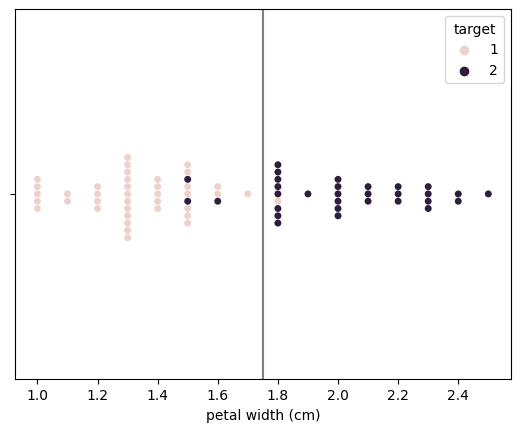

In [ ]:
data, labels, _, _ = split_test_val(iris_hard, 'target', val_rate = 0.3)
best_feature, best_treshold = select_attribute(data, labels, 'shannon')

print(f"Best Feature: {best_feature}")
print(f"Best Threshold: {best_treshold}")

data["target"] = labels

sns.swarmplot(data=data, x=data.columns[best_feature], hue="target")
plt.axvline(x=best_treshold, color='grey')

### Stopping Criterias

In [ ]:
def max_depth_stop(depth, max_depth):
  return depth==max_depth

def no_labels_to_split_stop(labels):
  return len(np.unique(labels)) == 1

def min_samples_split_stop(labels, min_samples_per_split):
  return len(labels) < min_samples_per_split

### Building the Tree

In [ ]:
def build_decision_tree(data, labels, depth=0, max_depth=10, min_samples_per_split=2, func_type='shannon'):
    # Initialize an empty root node
    node = Node()

    if max_depth_stop(depth, max_depth) or no_labels_to_split_stop(labels) or min_samples_split_stop(labels, min_samples_per_split):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = select_attribute(data, labels, func_type)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = build_decision_tree(left_data, left_labels, depth = depth+1,
                                              max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)
    if len(right_data) > 0:
        node.right_child = build_decision_tree(right_data, right_labels, depth = depth+1,
                                               max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)

    return node


In [ ]:
easy_train_X, easy_train_y, easy_test_X, easy_test_y = split_test_val(iris_easy, 'target', val_rate = 0.3)
easy_tree = build_decision_tree(easy_train_X, easy_train_y, max_depth=1)

hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_tree = build_decision_tree(hard_train_X, hard_train_y, max_depth=10)

#### Viewing Iris Trees

In [ ]:
def print_decision_tree(node, columns, indent=""):
    if node.is_leaf:
        print(indent + "Label:", node.label)
        return

    if not node.is_leaf:
        print(indent + columns[node.attribute] + " <= " + str(node.split_test))

    print(indent + "Left:")
    print_decision_tree(node.left_child, columns, indent + "  ")

    print(indent + "Right:")
    print_decision_tree(node.right_child, columns, indent + "  ")

In [ ]:
print_decision_tree(easy_tree, easy_train_X.columns)

petal length (cm) <= 2.5999999999999996
Left:
  Label: 0
Right:
  Label: 1


In [ ]:
print_decision_tree(hard_tree, hard_train_X.columns)

petal width (cm) <= 1.75
Left:
  sepal length (cm) <= 7.1
  Left:
    sepal width (cm) <= 2.8499999999999996
    Left:
      sepal width (cm) <= 2.25
      Left:
        petal length (cm) <= 4.75
        Left:
          Label: 1
        Right:
          Label: 2
      Right:
        petal width (cm) <= 1.55
        Left:
          petal length (cm) <= 5.0
          Left:
            Label: 1
          Right:
            Label: 2
        Right:
          Label: 1
    Right:
      Label: 1
  Right:
    Label: 2
Right:
  petal length (cm) <= 4.85
  Left:
    sepal length (cm) <= 5.95
    Left:
      Label: 1
    Right:
      Label: 2
  Right:
    Label: 2


## Predict & Error in Iris

In [ ]:
def _predict_single(node, instance):
    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        return _predict_single(node.left_child, instance)
    else:
        return _predict_single(node.right_child, instance)

def predict(root_node, data):
  predictions = [_predict_single(root_node, instance[1]) for instance in data.iterrows()]
  return predictions

def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

In [ ]:
easy_train_preds = predict(easy_tree, easy_train_X)
easy_test_preds = predict(easy_tree, easy_test_X)
error_easy_train = calculate_error(easy_train_preds, easy_train_y)
error_easy_test = calculate_error(easy_test_preds, easy_test_y)

hard_train_preds = predict(hard_tree, hard_train_X)
hard_test_preds = predict(hard_tree, hard_test_X)
error_hard_train = calculate_error(hard_train_preds, hard_train_y)
error_hard_test = calculate_error(hard_test_preds, hard_test_y)

print(f"Linear Separable IRIS Set: Training Error {error_easy_train}; Test Error: {error_easy_test}")
print(f"Non Linear Separable IRIS Set: Training Error {error_hard_train}; Test Error: {error_hard_test}")

Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.0
Non Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.03333333333333333


## The DecisionTree Class

In [ ]:
def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

def accuracy(predictions, labels):
    correct_predictions = np.sum(predictions == labels)
    return correct_predictions / len(labels)

def precision(predictions, labels):
    tp = np.sum((predictions == 1) & (labels == 1))
    fp = np.sum((predictions == 1) & (labels == 0))
    return (tp / (tp + fp))

def recall(predictions, labels):
    tp = np.sum((predictions == 1) & (labels == 1))
    fn = np.sum((predictions == 0) & (labels == 1))
    return tp / (tp + fn)

def specificity(predictions, labels):
    true_negatives = np.sum((predictions == 0) & (labels == 0))
    false_positives = np.sum((predictions == 1) & (labels == 0))
    return true_negatives / (true_negatives + false_positives)

def f1_score(predictions, labels):
    prec = precision(predictions, labels)
    rec = recall(predictions, labels)
    return  2 * (prec * rec) / (prec + rec)

class Node:
    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

In [234]:
class DecisionTree:
  def __init__(self, verbose=1, max_depth=10, min_samples_per_split=2, func_type='shannon', threshold_method='all', threshold_buckets=10, class_weights=[]):
    self.max_depth = max_depth
    self.min_samples_per_split = min_samples_per_split
    self.func_type = func_type
    self.threshold_method = threshold_method
    self.n_buckets = threshold_buckets
    self.verbose = verbose
    self.class_weights = class_weights
    self.cols = None
    self.root = None

  def fit(self, data, label):
    self.cols = data.columns
    self.root = self._build_decision_tree(data, label)

    if self.verbose==1:
      preds = self.predict(data, label)

    return self

  def predict(self, data, labels=[]):
    if not self.root:
      raise NotImplementedError("Model not yet fitted.")

    predictions = [self._predict_single(self.root, instance[1]) for instance in data.iterrows()]

    if len(labels):
      self.calc_metrics(predictions, labels)

    return predictions


  def print_tree(self, node=None, indent=""):
      if not self.root:
        raise NotImplementedError("Model not yet fitted.")

      if not node:
        node = self.root

      if node.is_leaf:
          print(indent + "Label:", node.label)
          return

      if not node.is_leaf:
          print(indent + self.cols[node.attribute] + " <= " + str(node.split_test))

      print(indent + "Left:")
      self.print_tree(node.left_child, indent + "  ")

      print(indent + "Right:")
      self.print_tree(node.right_child, indent + "  ")

  def calc_metrics(self, preds, label):
    preds = np.array(preds, dtype='int')
    label = label.to_numpy()
    print(f"Model Error: {calculate_error(preds, label)}")
    print(f"Model Accuracy: {accuracy(preds, label)}")
    print(f"Model Precision: {precision(preds, label)}")
    print(f"Model Recall: {recall(preds, label)}")
    print(f"Model Specificity: {specificity(preds, label)}")
    print(f"Model F1-Score: {f1_score(preds, label)}")
    return preds


  def _calculate_entropy(self, labels):
    # Get counts of zero and ones as vector
    values, counts = np.unique(labels, return_counts=True)

    # Normalize
    p_vec = counts / len(labels)
    if len(self.class_weights) and len(p_vec):
      weights = self.class_weights
      if len(values) == 1:
        weights = self.class_weights[values[0]]
      p_vec = p_vec*weights

    # Calculate proper entropy criterion
    if self.func_type == 'shannon':
      return -np.sum(p_vec * np.log2(p_vec))
    elif self.func_type == 'scaled':
      return -np.sum((p_vec/2) * np.log2(p_vec))
    elif self.func_type == 'gini':
      return 1 - np.sum(np.square(p_vec))

  def _calculate_information_gain(self, data, labels, left_labels, right_labels):
    total_entropy = self._calculate_entropy(labels)
    left_entropy = self._calculate_entropy(left_labels)
    right_entropy = self._calculate_entropy(right_labels)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain

  def _select_attribute(self, data, labels):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        thresholds = []
        if self.threshold_method == 'all':
          unique_values = np.unique(feature_values)
          # Get possible thresholds
          thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0
        elif self.threshold_method == 'bigdata':
          thresholds = np.percentile(feature_values, np.linspace(0, 100, self.n_buckets))

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
            # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = self._calculate_information_gain(data, labels, left_labels, right_labels)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

  def _max_depth(self, depth):
    return depth==self.max_depth

  def _no_labels_to_split(self, labels):
    return len(np.unique(labels)) == 1

  def _min_samples_split(self, labels):
    return len(labels) < self.min_samples_per_split

  def _build_decision_tree(self, data, labels, depth=0):
    # Initialize an empty root node
    node = Node()

    if self._max_depth(depth) or self._no_labels_to_split(labels) or self._min_samples_split(labels):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = self._select_attribute(data, labels)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = self._build_decision_tree(left_data, left_labels, depth = depth+1)
    if len(right_data) > 0:
        node.right_child = self._build_decision_tree(right_data, right_labels, depth = depth+1)

    return node

  def _predict_single(self, node, instance):

    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        if node.left_child is None:
          print(node.attribute)
          print(node.split_test)
        return self._predict_single(node.left_child, instance)
    else:
        if node.right_child is None:
          print(node.attribute)
          print(node.split_test)
        return self._predict_single(node.right_child, instance)

In [235]:
hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_train_y[hard_train_y == 2] = 0
hard_test_y[hard_test_y == 2] = 0

clf = DecisionTree()
clf = clf.fit(hard_train_X, hard_train_y)

Model Error: 0.0
Model Accuracy: 1.0
Model Precision: 1.0
Model Recall: 1.0
Model Specificity: 1.0
Model F1-Score: 1.0


In [236]:
clf.print_tree()

petal length (cm) <= 4.75
Left:
  Label: 1
Right:
  petal width (cm) <= 1.75
  Left:
    petal length (cm) <= 4.95
    Left:
      Label: 1
    Right:
      petal width (cm) <= 1.55
      Left:
        Label: 0
      Right:
        sepal length (cm) <= 6.95
        Left:
          Label: 1
        Right:
          Label: 0
  Right:
    petal length (cm) <= 4.85
    Left:
      sepal length (cm) <= 5.95
      Left:
        Label: 1
      Right:
        Label: 0
    Right:
      Label: 0


In [237]:
preds = clf.predict(hard_test_X, hard_test_y)

Model Error: 0.03333333333333333
Model Accuracy: 0.9666666666666667
Model Precision: 0.9166666666666666
Model Recall: 1.0
Model Specificity: 0.9473684210526315
Model F1-Score: 0.9565217391304348


## IBM Transaction Data DT

In [ ]:
hi_small_pandas = hi_small_model_input.sample(fraction=0.1, seed=42).toPandas()

In [ ]:
hi_small_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 459295 entries, 0 to 459294
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Day                          459295 non-null  int32  
 1   Hour                         459295 non-null  int32  
 2   From Bank                    459295 non-null  int32  
 3   To Bank                      459295 non-null  int32  
 4   AmtReceived                  459295 non-null  float32
 5   Is Laundering                459295 non-null  int32  
 6   Minute                       459295 non-null  int32  
 7   SelfPayment                  459295 non-null  int32  
 8   SameCurrencyTransaction      459295 non-null  int32  
 9   AmtReceivedRatio             459295 non-null  float64
 10  AccTransAmtInHour            459295 non-null  int64  
 11  AccTransAmtInDay             459295 non-null  int64  
 12  AccTransNumByHour            459295 non-null  int32  
 13 

In [ ]:
label_counts = hi_small_pandas["Is Laundering"].value_counts()
label_counts

0    458775
1       520
Name: Is Laundering, dtype: int64

In [238]:
class_weights = [1.0, label_counts[0]/label_counts[1]]
class_weights

[1.0, 882.2596153846154]

In [ ]:
hi_train_X, hi_train_y, hi_test_X, hi_test_y = split_test_val(hi_small_pandas, "Is Laundering", val_rate=0.2)

In [245]:
clf = DecisionTree(max_depth=15, threshold_method='bigdata', threshold_buckets=15, class_weights=class_weights)
clf = clf.fit(hi_train_X, hi_train_y)

Model Error: 0.00040279123439183965
Model Accuracy: 0.9995972087656082
Model Precision: 0.9964285714285714
Model Recall: 0.6549295774647887
Model Specificity: 0.9999972752786027
Model F1-Score: 0.7903682719546742


In [246]:
preds = clf.predict(hi_test_X, hi_test_y)

Model Error: 0.0009906487116123624
Model Accuracy: 0.9990093512883876
Model Precision: 0.52
Model Recall: 0.4148936170212766
Model Specificity: 0.9996076935650847
Model F1-Score: 0.4615384615384615


In [ ]:
clf.print_tree()

HourAccTransAmtToSameAcc <= 1.0
Left:
  CodedPaymentFormat <= 1.0
  Left:
    MinsSinceLastTrans <= 57.0
    Left:
      AmtReceived <= 633.9644368489584
      Left:
        Label: 0
      Right:
        Minute <= 30.0
        Left:
          Day <= 8.0
          Left:
            Label: 0
          Right:
            Minute <= 4.0
            Left:
              Day <= 9.0
              Left:
                Label: 0
              Right:
                To Bank <= 904.6666666666653
                Left:
                  CodedCurrency <= 5.111111111111111
                  Left:
                    Label: 0
                  Right:
                    Label: 1
                Right:
                  Label: 0
            Right:
              Label: 0
        Right:
          AmtReceived <= 12123.039822048613
          Left:
            CodedPaymentFormat <= 0.0
            Left:
              Label: 0
            Right:
              Day <= 1.0
              Left:
                To B

# 2. Distributed Workers